## Deep Learning Black-Scholes Formula - II. Neural network from scratch

In [1]:
import numpy as np
import torch
import csv
import matplotlib.pyplot as plt

In [2]:
dataset = []
with open('../data/black_scholes_with_greeks.csv', newline='\n') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    dataset.append(row)

train_set, test_set = np.array(dataset[:240000], dtype=float), np.array(dataset[240000:], dtype=float)
train_features, train_labels = torch.from_numpy(train_set[:, 0:5]), torch.from_numpy(train_set[:, 5]).reshape(-1, 1)
test_features, test_labels = torch.from_numpy(test_set[:, 0:5]), torch.from_numpy(test_set[:, 5]).reshape(-1, 1)

In [3]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features, train_labels),
                                         batch_size,
                                         shuffle=True)
test_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_features, test_labels),
                                        batch_size,
                                        shuffle=False)


In [4]:
num_inputs = 5
num_hidden = 100
num_outputs = 1

w1 = torch.nn.Parameter(torch.randn(num_inputs, num_hidden, requires_grad=True) * .01)
b1 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w2 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .01)
b2 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w3 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .01)
b3 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w4 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .01)
b4 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w5 = torch.nn.Parameter(torch.randn(num_hidden, num_outputs, requires_grad=True) * .01)
b5 = torch.nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [w1, b1, w2, b2, w3, b3, w4, b4, w5, b5]

class Model(torch.nn.Module):
  def __init__(self, params) -> None:
    super(Model, self).__init__()
    self.softplus = torch.nn.Softplus()
    self.w1 = params[0]
    self.b1 = params[1]
    self.w2 = params[2]
    self.b2 = params[3]
    self.w3 = params[4]
    self.b3 = params[5]
    self.w4 = params[6]
    self.b4 = params[7]
    self.w5 = params[8]
    self.b5 = params[9]

  def forward(self, x):
    out = self.softplus(x)
    out = self.softplus(torch.matmul(out,   self.w1) + self.b1)
    out = self.softplus(torch.matmul(out, self.w2) + self.b2)
    out = self.softplus(torch.matmul(out, self.w3) + self.b3)
    out = self.softplus(torch.matmul(out, self.w4) + self.b4)
    out = torch.matmul(out, self.w5) + self.b5
    return out

model = Model(params)

In [5]:
loss = torch.nn.MSELoss()

In [23]:
learning_rate = 0.0004
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [24]:
num_epochs = 1
for epoch in range(num_epochs):
  for X, y in train_iter:
    l = loss(model(X.float()), y.float())

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

  l = loss(model(train_features.float()), train_labels.float())
  print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.005247


In [25]:
with torch.no_grad():
  print(model(train_features[:5].float()))
  print(train_labels[:5].float())

tensor([[1.4030e-02],
        [4.2011e-02],
        [2.1504e-01],
        [3.4038e+01],
        [8.8543e-03]])
tensor([[0.0000e+00],
        [1.0551e-02],
        [2.4765e-01],
        [3.4387e+01],
        [5.1302e-14]])


In [26]:
with torch.no_grad():
  l = loss(model(test_features.float()), test_labels.float())
  print(f'loss {l:f}')

loss 0.005158


In [27]:
torch.save(model.state_dict(), '../save/black_scholes_scratch.ckpt')

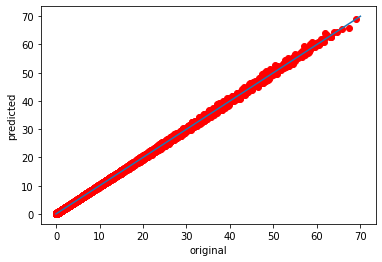

In [28]:
with torch.no_grad():
  predicted = model(train_features.float()).numpy().reshape(-1)
  original = train_labels.numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 70], [0, 70])
  plt.show()

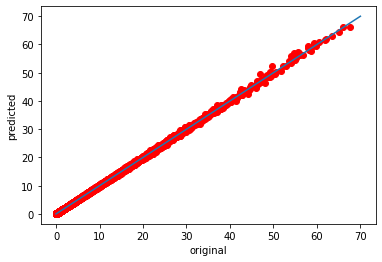

In [29]:
with torch.no_grad():
  predicted = model(test_features.float()).numpy().reshape(-1)
  original = test_labels.numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 70], [0, 70])
  plt.show()